This tutorial reproduces the results of Tutorial 38 on spinw.org. It reproduces the dispersion of the T and T' modes of Ca2RuO4 based on the parameters obtained from "Nat. Phys. 13, 633 (2017)"

Get Packages

In [1]:
using Sunny,GLMakie,CairoMakie,LinearAlgebra

Set up the system. Ruthenium is a rare earth element and hence its spin depends on the crystal field. Here, S=1 has been assigned to Ru4+ atoms. Parameters were obtained from the cif file. The space group is Pbca or 61. Note that a setting is required so that Sunny can perform calculations on the system.

In [2]:
a = 5.4097;
b = 5.4924;
c = 11.9613;

latvecs = lattice_vectors(a, b, c, 90, 90, 90)
positions=[[0, 0, 0]]
cryst= Crystal(latvecs,positions,61;setting="")
GLMakie.activate!()
view_crystal(cryst)
print_symmetry_table(cryst,8)
sys=System(cryst, (1,1,1),[SpinInfo(1,S=1,g=2)], :dipole, seed=0)

Atom 1
Position [0, 0, 0], multiplicity 4
Allowed g-tensor: [  A F+I E-H
                   F-I   B D+G
                   E+H D-G   C]
Allowed anisotropy in Stevens operators:
    c₁*𝒪[2,-2] + c₂*𝒪[2,-1] + c₃*𝒪[2,0] + c₄*𝒪[2,1] + c₅*𝒪[2,2] +
    c₆*𝒪[4,-4] + c₇*𝒪[4,-3] + c₈*𝒪[4,-2] + c₉*𝒪[4,-1] + c₁₀*𝒪[4,0] + c₁₁*𝒪[4,1] + c₁₂*𝒪[4,2] + c₁₃*𝒪[4,3] + c₁₄*𝒪[4,4] +
    c₁₅*𝒪[6,-6] + c₁₆*𝒪[6,-5] + c₁₇*𝒪[6,-4] + c₁₈*𝒪[6,-3] + c₁₉*𝒪[6,-2] + c₂₀*𝒪[6,-1] + c₂₁*𝒪[6,0] + c₂₂*𝒪[6,1] + c₂₃*𝒪[6,2] + c₂₄*𝒪[6,3] + c₂₅*𝒪[6,4] + c₂₆*𝒪[6,5] + c₂₇*𝒪[6,6]

Bond(1, 2, [0, 0, 0])
Distance 3.8545853165418, coordination 4
Connects [0, 0, 0] to [1/2, 1/2, 0]
Allowed exchange matrix: [  A F+I E-H
                          F-I   B D+G
                          E+H D-G   C]
Allowed DM vector: [G H I]

Bond(1, 1, [1, 0, 0])
Distance 5.4097, coordination 2
Connects [0, 0, 0] to [1, 0, 0]
Allowed exchange matrix: [A F E
                          F B D
                          E D C]

Bond(1, 1, [0, 1, 0])
Distance 5

System [Dipole mode]
Lattice (1×1×1)×4
Energy per site 0


Set up the exchanges. Not that here the single ion anisotropy is in the form of a matrix. The diagonal values have been taken to form D vector, since all other elements of Amat are zero. Also, anisotropy value need to be doubled in Sunny to obtain the correct results. Randomize the spins and minimize the energy to obtain the ground state.

In [3]:
J = 5.2;
a = 0.10*J;
e = 1;
E = 21.5;
X = 1.0;

Jmat=[J X 0;X J 0;0 0 J-a]
Amat=[e 0 0; 0 0 0; 0 0 E]
D=[e,0,E] ###diagonal elements of Amat

set_exchange!(sys,Jmat,Bond(1, 2, [0, 0, 0]))
S=spin_operators(sys,1)
set_onsite_coupling!(sys,S->2*e*S[1]^2+2*E*S[3]^2,1)
randomize_spins!(sys)
minimize_energy!(sys)
plot_spins(sys)


┌ Warning: `spin_operators` will soon be removed! Use `spin_matrices(spin_label(sys, i))` instead.
└ @ Sunny /Users/bhushanthipe/.julia/packages/Sunny/Kmqzx/src/deprecated.jl:10


Set up the LSWT object and a path to obtain the dispersion and intensity bands.

In [4]:
q_points=[[0.5,0,0],[0.5,0.5,0],[1,0.0,0],[0,0,0],[0.5,0.5,0]]
density = 200
path, xticks = reciprocal_space_path(cryst, q_points, density);
swt=SpinWaveTheory(sys)
formula = intensity_formula(swt, :perp; kernel=delta_function_kernel)
disp, intensity = intensities_bands(swt, path, formula);

Plot the dispersion and convoluted spectra

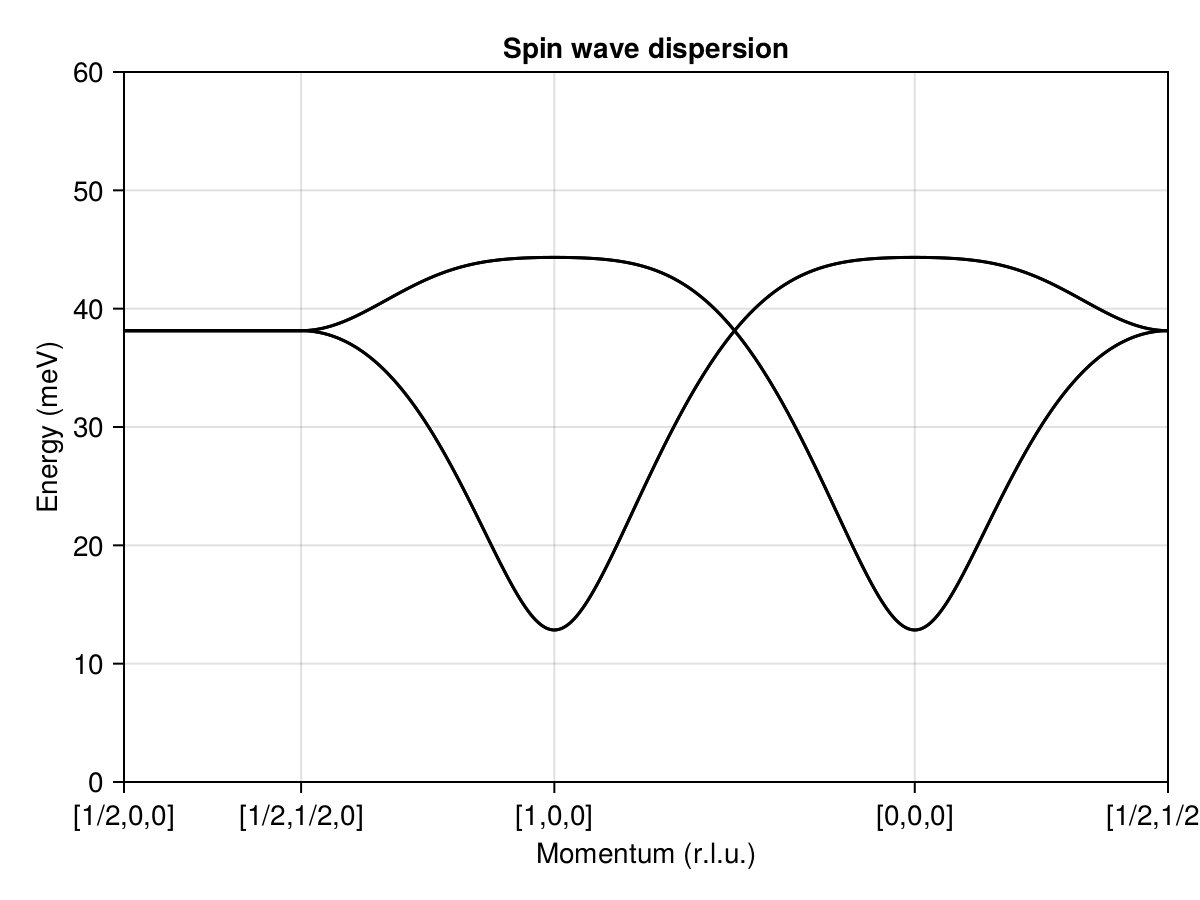

In [5]:
CairoMakie.activate!()
fig = Figure()
ax = Axis(fig[1,1]; xlabel="Momentum (r.l.u.)", ylabel="Energy (meV)",title="Spin wave dispersion", xticks)
ylims!(ax, 0.0, 60)
xlims!(ax, 1, size(disp, 1))
colorrange = extrema(intensity)
for i in axes(disp)[2]
    lines!(ax, 1:length(disp[:,i]), disp[:,i];color="black", colorrange)
end
fig

Here we need to calculate Sxx+Syy+Szz first

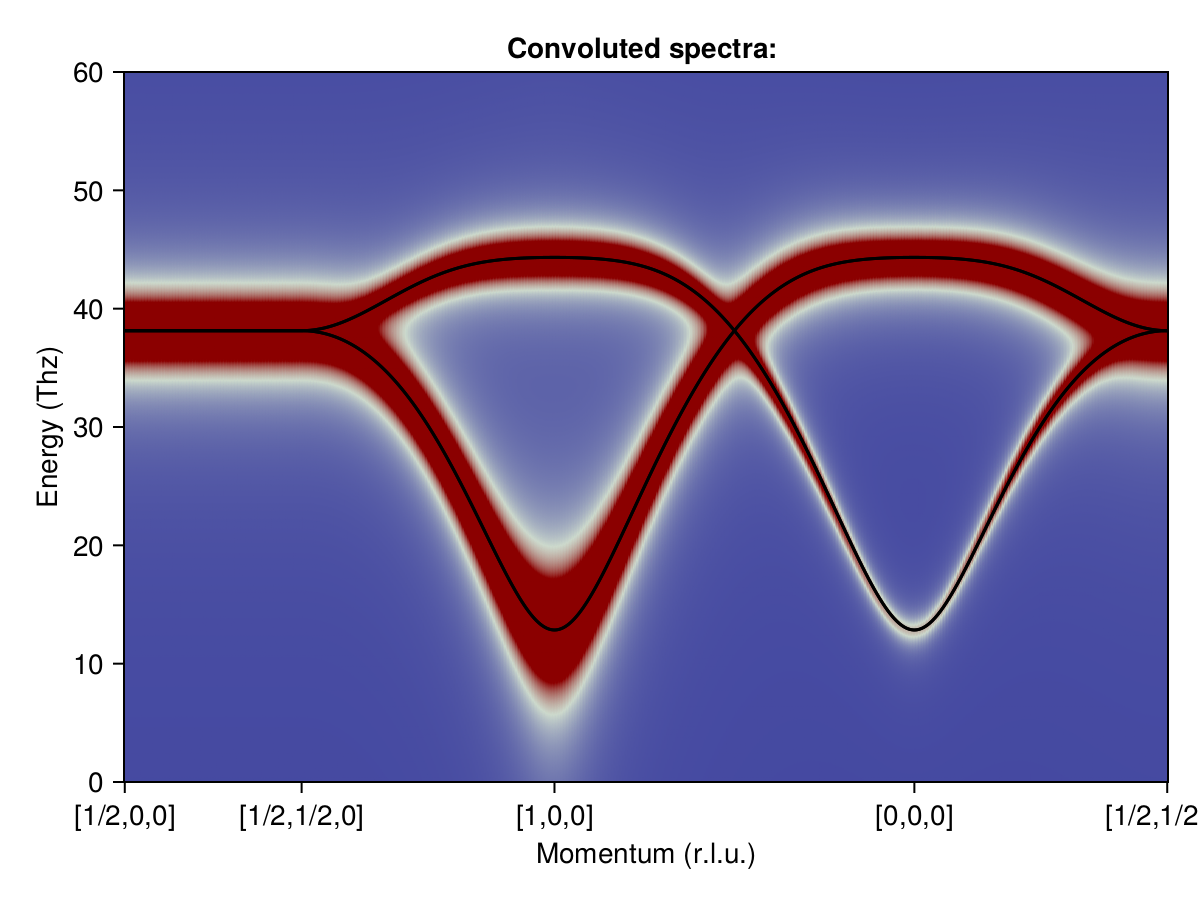

In [11]:
γ = 1;
broadened_formula = intensity_formula(swt, :full; kernel=lorentzian(γ));
energies = collect(0:0.02:140);
is = intensities_broadened(swt, path, energies, broadened_formula);
is1=zeros(ComplexF64,length(path),length(energies));
for i  in 1:length(path)
    for j in 1:length(energies)
        is1[i,j] = is[i,j][1,1]+is[i,j][2,2]+is[i,j][3,3]###Sxx+Syy+Szz
    end
end 

CairoMakie.activate!()
fig = Figure()
ax = Axis(fig[1,1]; xlabel="Momentum (r.l.u.)", ylabel="Energy (Thz)", title="Convoluted spectra: ", xticks);
ylims!(ax, 0.0,60.0);
pl=heatmap!(ax, 1:size(is, 1), energies,real(is1),colorrange=(-0.01,0.05));
pl.colormap = Reverse(:redsblues);
for i in axes(disp)[2]
    lines!(ax, 1:length(disp[:,i]), disp[:,i]; color="black")
end
fig